# Classification - Example
In this script we demonstrate how a Machine Learning workflow can look like when you use a train, validation and test set. 

<h1>Project</h1>

<h3>Loading Data</h3>

In [1]:
# Import MNIST dataset
from keras.datasets import mnist
import numpy as np

# Look at the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

2024-03-28 09:09:58.694448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Data Preprocessing</h3>

<h5>Constants</h5>

In [2]:
DATA_SIZE = X_train.shape[0]
SCALE_FACTOR = 255.0
IMG_SIZE = 28
PAD = 3

<h5>Data Normalization</h5>

In [3]:
# Scale the pixel values for all images in the database to 0-1
X_train_scaled = X_train / SCALE_FACTOR
X_test_scaled = X_test / SCALE_FACTOR
# X_test = X_test.reshape(-1, IMG_SIZE*IMG_SIZE)

<h5>Data Subdivision</h5>

In [4]:
# Given length of each subdivision of the training set, divide the training set into 3 parts
nbr_parts = 3
part_length = DATA_SIZE // nbr_parts
DATA_MIDPOINT = DATA_SIZE // 2
start_img_svc = 0
stop_img_svc = part_length
start_img_rfc = int(DATA_MIDPOINT - (part_length / 2))
stop_img_rfc = int(DATA_MIDPOINT + (part_length / 2))
start_img_xgb = DATA_SIZE - part_length
stop_img_xgb = DATA_SIZE

# print them all
print(start_img_svc, stop_img_svc)
print(start_img_rfc, stop_img_rfc)
print(start_img_xgb, stop_img_xgb)

0 20000
20000 40000
40000 60000


<h3>Feature Selection</h3>

Number of Dimensions = 152


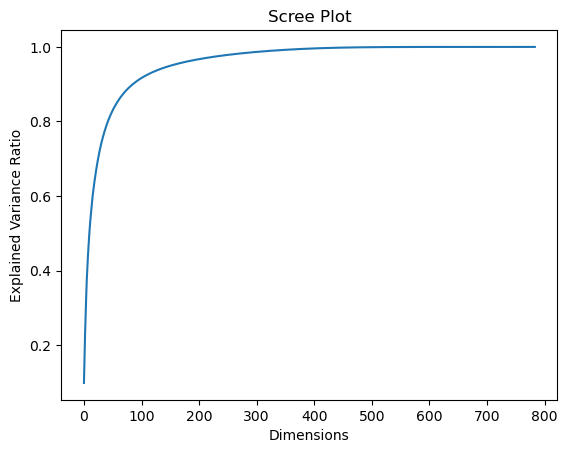

In [5]:
# Try dimensionality reduction with PCA and show the number of dimensions that explain 95% of the variance and the explained variance ratio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train_HERE = X_train_scaled

pca = PCA()
pca.fit(X_train_HERE[:part_length].reshape(-1, IMG_SIZE*IMG_SIZE))
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"Number of Dimensions = {d}")

# Plot the scree plot of the explained variance ratio
plt.plot(cumsum)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

<h3>Model Selection and Training with Hyperparameter Optimization<h3>

In [6]:
# Prepare for saving the upcoming models
import joblib

X_train_scaled.shape

(60000, 28, 28)

<h5>Support Vector Classifier</h5>

In [7]:
# Try dimensionality reduction with PCA and show the number of dimensions that explain 95% of the variance and the explained variance ratio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train_HERE = X_train_scaled
y_train_HERE = y_train

# Use part of the training set, as specified in the beginning
X_train_svc = X_train_HERE[start_img_svc:stop_img_svc].reshape(-1, IMG_SIZE*IMG_SIZE)
y_train_svc = y_train_HERE[start_img_svc:stop_img_svc]
pca_svc = PCA()
pca_svc.fit(X_train_svc)
cumsum_svc = np.cumsum(pca_svc.explained_variance_ratio_)
d_svc = np.argmax(cumsum_svc >= 0.95) + 1
print(f"Number of Dimensions = {d_svc}")

Number of Dimensions = 152


In [8]:
# First implement reduce the dimensions of the training set using PCA and then train the model using the best parameters
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pca_svc = PCA(n_components=d_svc)
X_train_svc_pca = pca_svc.fit_transform(X_train_svc)
X_test_svc_pca = pca_svc.transform(X_test_scaled.reshape(-1, IMG_SIZE*IMG_SIZE))

# 'C': 633515148.5450886, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'
model_svc = SVC(C=633515148.5450886, kernel='rbf', degree=4, gamma='scale', probability=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(y_train_svc.shape)

score = cross_val_score(model_svc, X_train_svc_pca, y_train_svc, cv=kfold, scoring='accuracy')
accuracy = score.mean()
print(f"{accuracy*100:.2f}%")

(20000,)
97.89%


['model_svc_pca.joblib']

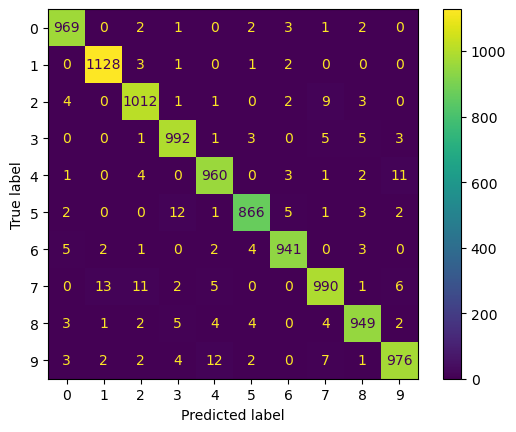

In [9]:
# Run the model on the test set and show the accuracy, classification report, and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_svc.fit(X_train_svc_pca, y_train_svc)
y_pred_svc = model_svc.predict(X_test_svc_pca)
accuracy = np.mean(y_pred_svc == y_test)
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()

# Save the model to a file
joblib.dump(model_svc, 'model_svc_pca.joblib')

<h5>Random Forest Classifier</h5>

In [10]:
# Try dimensionality reduction with PCA and show the number of dimensions that explain 95% of the variance and the explained variance ratio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train_HERE = X_train_scaled
y_train_HERE = y_train

# Use part of the training set as specified in the beginning
X_train_rfc = X_train_HERE[start_img_rfc:stop_img_rfc].reshape(-1, IMG_SIZE*IMG_SIZE)
y_train_rfc = y_train_HERE[start_img_rfc:stop_img_rfc]

pca_rfc = PCA()
pca_rfc.fit(X_train_rfc)
cumsum_rfc = np.cumsum(pca_rfc.explained_variance_ratio_)
d_rfc = np.argmax(cumsum_rfc >= 0.95) + 1
print(f"Number of Dimensions = {d_rfc}")

Number of Dimensions = 153


In [11]:
# Train a random forest classifier with the parameters 'n_estimators': 185, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini' on the test set
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

pca_rfc = PCA(n_components=d_rfc)
X_train_rfc_pca = pca_rfc.fit_transform(X_train_rfc)
X_test_rfc_pca = pca_rfc.transform(X_test_scaled.reshape(-1, IMG_SIZE*IMG_SIZE))

model_rfc = RandomForestClassifier(n_estimators=185, max_depth=31, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', criterion='gini')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_rfc = cross_val_score(model_rfc, X_train_rfc_pca, y_train_rfc, cv=kfold, scoring='accuracy')
accuracy_rfc = score_rfc.mean()
print(f"{accuracy_rfc*100:.2f}%")

# Save this model to a file
joblib.dump(model_rfc, 'model_rfc.joblib')

93.23%


['model_rfc.joblib']

96.18%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.94      0.95      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



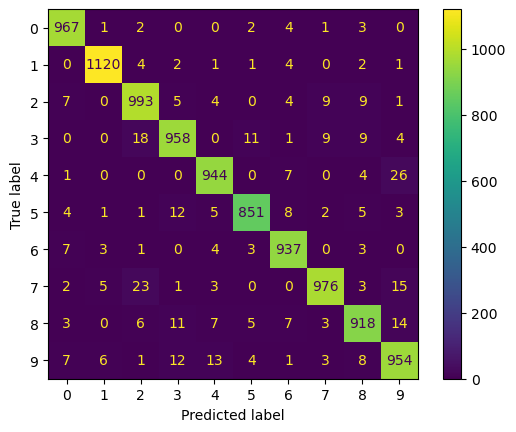

In [12]:
# Run the model on the test set and show the accuracy, classification report, and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_rfc.fit(X_train_rfc, y_train_rfc)
y_pred_rfc = model_rfc.predict(X_test_scaled.reshape(-1, 28*28))
accuracy = np.mean(y_pred_rfc == y_test)
print(f"{accuracy*100:.2f}%")
print(classification_report(y_test, y_pred_rfc))
cm = confusion_matrix(y_test, y_pred_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()

<h5>Extreme Gradient Boosting Classifier</h5>

In [13]:
# Try dimensionality reduction with PCA and show the number of dimensions that explain 95% of the variance and the explained variance ratio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train_HERE = X_train_scaled
y_train_HERE = y_train

# Use the whole training set, as this is our main model
X_train_xgb = X_train_HERE[start_img_xgb:stop_img_xgb].reshape(-1, IMG_SIZE*IMG_SIZE)
y_train_xgb = y_train_HERE[start_img_xgb:stop_img_xgb]

pca_xgb = PCA()
pca_xgb.fit(X_train_xgb)
cumsum_xgb = np.cumsum(pca_xgb.explained_variance_ratio_)
d_xgb = np.argmax(cumsum_xgb >= 0.95) + 1
print(f"Number of Dimensions = {d_xgb}")

Number of Dimensions = 154


In [14]:
# Train an XGBoost model with the parameters 'n_estimators': 159, 'max_depth': 18, 'learning_rate': 0.16359180406728466, 'subsample': 0.9607608761620962, 'colsample_bytree': 0.24259625214461825, 'gamma': 2.825637469844936e-09' on the test set
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

pca_xgb = PCA(n_components=d_xgb)
X_train_xgb = pca_xgb.fit_transform(X_train_xgb)
X_test_xgb = pca_xgb.transform(X_test_scaled.reshape(-1, IMG_SIZE*IMG_SIZE))

model_xgb = xgb.XGBClassifier(n_estimators=159, max_depth=18, learning_rate=0.16359180406728466, subsample=0.9607608761620962, colsample_bytree=0.24259625214461825, gamma=2.825637469844936e-09)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_xgb = cross_val_score(model_xgb, X_train_xgb, y_train_xgb, cv=kfold, scoring='accuracy')
accuracy_xgb = score_xgb.mean()
print(f"{accuracy_xgb*100:.2f}%")

# Save this model
joblib.dump(model_xgb, 'model_xgb.joblib')

94.38%


['model_xgb.joblib']

95.10%
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.95      0.95       982
           5       0.94      0.94      0.94       892
           6       0.96      0.97      0.96       958
           7       0.95      0.94      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



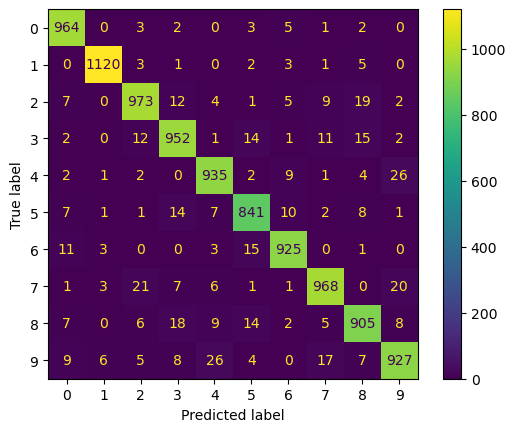

In [15]:
# Run the model on the test set and show the accuracy, classification report, and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)
accuracy = np.mean(y_pred_xgb == y_test)
print(f"{accuracy*100:.2f}%")
print(classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()

<h3>Ensemble Voting</h3>

In [16]:
# Using the three models, train an ensemble model with the best parameters
from sklearn.ensemble import VotingClassifier

# Retreive the models from the files
model_svc = joblib.load('model_svc.joblib')
model_rfc = joblib.load('model_rfc.joblib')
model_xgb = joblib.load('model_xgb.joblib')

model_ensemble = VotingClassifier(estimators=[
    ('svc', model_svc),
    ('rfc', model_rfc),
    ('xgb', model_xgb)
], voting='soft')

In [17]:
# Train the ensemble model on the test set
model_ensemble.fit(X_train_scaled.reshape(-1, IMG_SIZE*IMG_SIZE), y_train)
y_pred_ensemble = model_ensemble.predict(X_test_scaled.reshape(-1, IMG_SIZE*IMG_SIZE))
accuracy_ensemble = np.mean(y_pred_ensemble == y_test)
print(f"{accuracy_ensemble*100:.2f}%")

# Save the ensemble model to a file
joblib.dump(model_ensemble, 'model_ensemble.joblib')

98.20%


['model_ensemble.joblib']

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



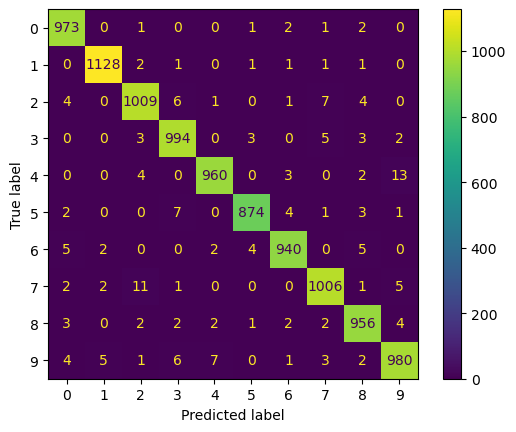

In [18]:
# Plot the confusion matrix of the ensemble model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=np.unique(y_test))
disp_ensemble.plot()

# Calculate the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_ensemble))

TODO : Due to the lack of time, PCA was chosen in beforehand and the kernel was decided to be RBF.

TODO : Add as argument for why PCA does not improve the model. That's because the model is not using regularization and the model is not overfitting. In other words, the model is not complex enough to benefit from PCA.

TODO : Implement a pipeline for the whole process of data preprocessing, model training and evaluation.

TODO : Try normalization or argue why it is not necessary.

TODO : Try other methods for feature engineering

TODO : Use the whole dataset

TODO : Use several models at the same time and use cross validation to choose the best.

TODO : REMEMBER TO LOOK AT HOW THE FINAL MODEL CALSSIFIES DIFFERENT DIGITS.

LATER TODO : Implement a code that rotates the numbers in the images around the z-axis